**Model Source:**<br />
https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/dla_simple.py

# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from fastprogress import progress_bar, master_bar

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [4]:
from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.scaleFunctions import *
from utilities.pcaFunctions import *

In [5]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Paths

In [9]:
paths = fetchPaths(base, DATASET, '', False)
path_data = paths['data']

# GPU Device & Seed

In [10]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [11]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

## Load model and settings

In [6]:
# transformers
tf_train = T.Compose([
    T.ToTensor(),
    T.Normalize((0.3381, 0.3101, 0.3194), (0.1625, 0.1625, 0.1721))
])

tf_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.3381, 0.3101, 0.3194), (0.1625, 0.1625, 0.1721))
])

In [7]:
class GTSRB_CNN(nn.Module):
    def __init__(
        self, channels=3, img_dim=30, outneurons=43, last_hidden_neurons=80, first_layer_norm=False,
        weight_init='kaiming_uniform', bias=False, dropout=0.0, batchnorm=True
    ):

        super(GTSRB_CNN, self).__init__()

        self.channels = channels
        self.img_dim = img_dim
        self.in_features = channels * img_dim * img_dim
        self.num_classes = outneurons
        self.last_hidden_neurons = last_hidden_neurons
        self.dropout_p = dropout
        self.batchnorm = batchnorm
        self.first_layer_norm = first_layer_norm

        # uniform(-1/sqrt(in_features), 1/sqrt(in_features))
        weights = {
            "normal": nn.init.normal_,
            "xavier": nn.init.xavier_normal_,
            "xavier_uniform": nn.init.xavier_uniform_,
            "kaiming": nn.init.kaiming_normal_,
            "kaiming_uniform": nn.init.kaiming_uniform_,
        }

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # scaling data
        self.scaleInputs = nn.BatchNorm2d(channels)
        self.dropout_l = nn.Dropout(self.dropout_p)
        self.pool = nn.MaxPool2d(2, 2)


        self.cn1 = nn.Conv2d(channels, 128, 5, bias=bias)
        self.bn1 = nn.BatchNorm2d(128)

        self.cn2 = nn.Conv2d(128, 128, 3, bias=bias)
        self.bn2 = nn.BatchNorm2d(128)

        self.cn3 = nn.Conv2d(128, 64, 2, bias=bias)
        self.bn3 = nn.BatchNorm2d(64)

        self.cn4 = nn.Conv2d(64, 64, 2, bias=bias)
        self.bn4 = nn.BatchNorm2d(64)

        self.fc5 = nn.Linear(64 * 4 * 4, last_hidden_neurons, bias=bias)
        self.bn5 = nn.BatchNorm1d(last_hidden_neurons)

        self.output = nn.Linear(last_hidden_neurons, outneurons, bias=bias)


        if weight_init:
            self.__weight_init(weights[weight_init], bias)


    def forward(self, x):

        x = self._train(x)
        if self.batchnorm: x = self.bn5(x)
        x = self.relu(x)
        x = self.output(x)

        return x


    def _train(self, x):

        if self.first_layer_norm: x = self.scaleInputs(x)

        x = self.pool(self.relu(self.bn1(self.cn1(x))))
        x = self.pool(self.relu(self.bn2(self.cn2(x))))

        x = self.relu(self.bn3(self.cn3(x)))
        x = self.relu(self.bn4(self.cn4(x)))

        x = self.flatten(x)
        x = self.dropout_l(x)
        x = self.fc5(x)

        return x

    def output_last_layer(self, x):

        x = self._train(x)
        out = x.clone().detach()
        if self.batchnorm: x = self.bn5(x)
        x = self.relu(x)
        x = self.output(x)

        return out, x

    def _sum_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.sum()

        return total_weights.item()

    def _sum_abs_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return total_weights.item()

    def _l1_regularization(self, alpha=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return alpha * total_weights

    def _l2_regularization(self, lambd=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.pow(2).sum()

        return lambd * total_weights

    def _elastic_regularization(self, lambd=1e-3, alpha=1e-3):
        return self._l2_regularization(lambd) + self._l1_regularization(alpha)

    def __weight_init(self, fn, bias):

        for m in self.modules():

            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
               ):
                fn(m.weight)

                if bias:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

### Configurations

In [42]:
model_ = GTSRB_CNN

lhl = 30

model_setup = {
    "batchnorm": 1,
    "dropout": 0.2
}

model_config= {
    "batch_size": 32,
    "lr": 0.01,
    "epochs": 30,
    "patience": 4,
    "L2": 1e-5,
    "L1": 1e-5
}

# Load / Split / DataLoader

In [14]:
feature_names = get_labels(DATASET)

train_data = get_dataset(DATASET, path_data, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_data, train=False, transform=tf_test)
len(train_data), len(test_data)

(42495, 6399)

In [15]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

In [17]:
tf_denormalize = T.Normalize(
    mean=[-m / s for m, s in zip(tf_train.transforms[-1].mean, tf_train.transforms[-1].std)],
    std=[1/s for s in tf_train.transforms[-1].std]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


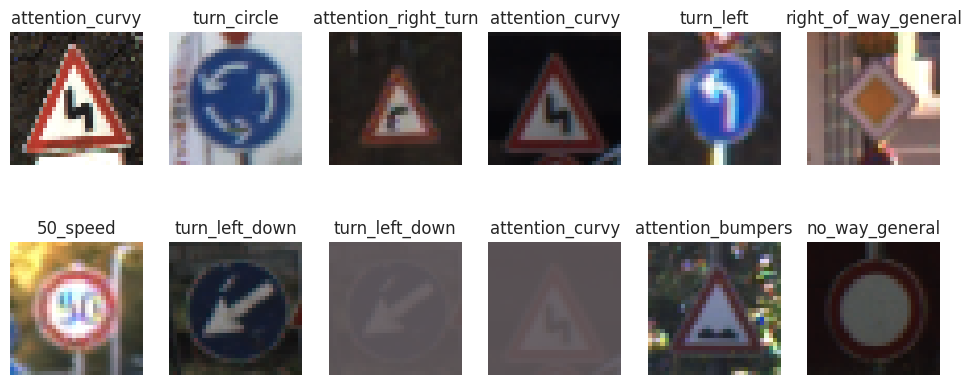

In [40]:
show_images_loader(trainloader, feature_names=feature_names, transform=tf_denormalize)

# Helper Functions

In [43]:
model_setup['last_hidden_neurons'] = lhl

model = model_(**model_setup).to(device)
model = torch.compile(model)
nn.DataParallel(model, device_ids=[CUDA])

DataParallel(
  (module): OptimizedModule(
    (_orig_mod): GTSRB_CNN(
      (relu): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (scaleInputs): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_l): Dropout(p=0.2, inplace=False)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (cn1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn3): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(64, eps=1e-

In [44]:
# loss function
loss_function = nn.CrossEntropyLoss()

optim_name = 'AdamW'
optim_args = {}

scheduler_name = 'MultiStepLR'
scheduler_args = {'milestones': [5, 20, 25]}

# optimizer and scheduler
optimizer = getattr(torch.optim, optim_name)(model.parameters(), lr=model_config['lr'], **optim_args)
scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, **scheduler_args)

In [45]:
# training testing attributes
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': scheduler,
    'map_classes': None,
    'skip_classes': None,
    'device': device,
    'model_path': None,
    'trainloader': trainloader,
    'testloader': testloader,
    'config': model_config
}


## Run Training

In [47]:
# train
train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = \
run_training_testing(**kwargs)

[2023-07-12 17:30:50,826] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
